## MNIST

We will be using MNIST dataset, which is a set of 70000 small images of digits handwritten by high school students and employees of the US central Bureaus. 

Each image has 784 features. This is because each image is 28 x 28 pixels, and each feature simply represents one pixel's intesity, from 0 (white) to 255 (black).

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


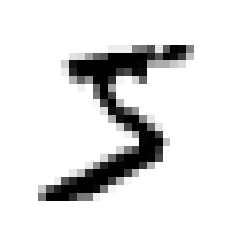

In [10]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [11]:
y[0]

'5'

Note that the label is a string. Most ML algorithms expect numbers, so let's cast y to integer

In [12]:
y = y.astype(np.uint8)

We should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually split into a training set (the first 60000 images) and a test set (the last 10000 images).

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good because thids guarantees that all cross-validation folds will be similar.

## Training a Binary Classifier

Let's simplify the problem for now and only try to identify one digit (for example, the number 5). This "5-detector" will be a n example of binary classifier.

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Now we can use it to detect images of the number 5:

In [16]:
sgd_clf.predict([some_digit])

array([ True])

## Implementing Cross-Validation

Occassionally we will need more control over the cross-validation process than what Scikit-Learn provides off the shell. In these cases, we can implement cross-validation.

In [17]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


Let's use the cross_val_score() function to evaluate our SGDclassifier model, using the K-fold cross-validation with three folds.

In [18]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Above 93% of accuracy on all cross-validation folds. This looks amazing, doesn't it? Well, let's look at a very dumb classifier that just classifiers every single image in the "not-5" class

In [19]:
class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Let's find out the accuracy of the model:

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

It has over 90% of accuracy! This is because only about 10% of the images are 5's

## Confusion matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. In order to do so, we need to use the cross_val_predict function:

In [21]:
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
confusion_matrix(y_train_5, y_train_predict)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class.

## Precision and recall

In [23]:
precision_score(y_train_5, y_train_predict)
recall_score(y_train_5, y_train_predict)
f1_score(y_train_5, y_train_predict)

0.7325171197343846

## Precision/Recall Trade-off

Scikit-Learn does not let us set the threshold directly, but it does give us access to the decision scores that it uses to make predictions. 

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


How do we decide which threshold to use? First, use the cross_val_predict() function to get th scores of all instances in the training set, but this time specify that we want to return decision scores instead of predictions:

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [26]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Precision")
    
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b--")

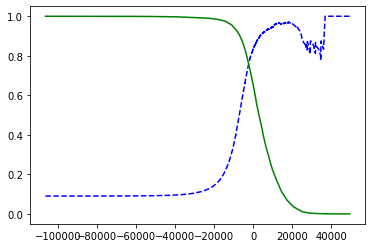

In [28]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

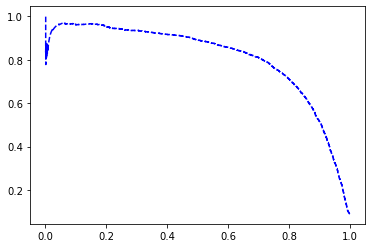

In [29]:
plot_precision_vs_recall(precisions, recalls)
plt.show()

Precision really starts to fall sharply around 80% recall. We will probably want to select a precision/recall trade-off just before the drop.
Suppose we decide to aim for 90% precision. We will look up the first plot and find that we need to use a threshold of about 8000. To be more precise, we can search for the lowest threshold that gives us at least 90% precision.

In [30]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

To make predictions, we will run the following code:

In [31]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


## The Roc Curve

The ROC curve is another common tool used with binary classification. The ROC plots the true positive rate (another name for recall) agains false positive rate.

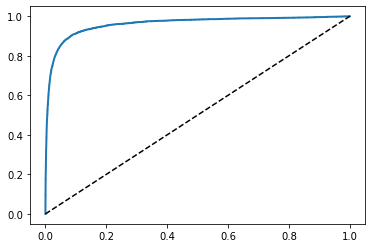

In [32]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equeal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [33]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let's now train a RandomForestClassifier and compare its ROC curve and ROC AUC score to those of the SGDClassifier.

In [34]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [35]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class

In [36]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

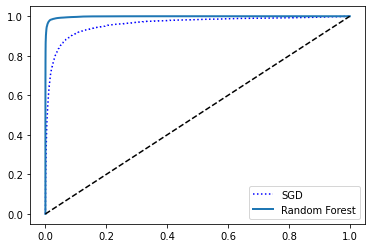

In [37]:
plt.plot(fpr, tpr, "b:", label="SGD") 
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

Whereas binary classifiers distingguish between two classes, multiclass classifiers can distinguish between more than two classes.

Some algorithms (such as SGD classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively. Others (such as Logistic REgression or SVM classifiers) are strictly binary classifiers.

One way to create a system that can classify the digit images into 10 classes is to train 10 binary classifiers, one for each digit. Then, when you want to classify an image, you get the decision score from each classifier for that image and yet select the class whose classifier outputs the highest score. This is called then one-versus-the-rest (OvR) strategy.

Another way is to train a binary classifier for every pair of digits: one to distinguish 0 and 1, another to distinguish 0 and 2, and so on. THen, when we want to take a decision, we select the class that has won most of the duels. This is called one-versus-one strategy.

Let's use a SVM classifier.

In [39]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train) #y_train, not y_train_5

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [40]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

If we call the decision_function() method, we will see that it returns 10 scores per instance. That's one score per class

In [41]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

If we want to force Scikit.Learn to use one-versus-one or one-versus-the-rest, we can use the OneVsOneClassifier or OneVsRestClassifier classes

In [44]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [47]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

## Error Analysis

Let's analyse the errors a model can make. First, look at the confusion matrix. We will need to make predictions using the cross_val_predict() function, then call the confusion_matrix() function, just like we did earlier:

In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [50]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

That's a lot of numbers. It's often more convenient to look at an image representation of the confusion matrix, using Matplotlib's matshow() function:

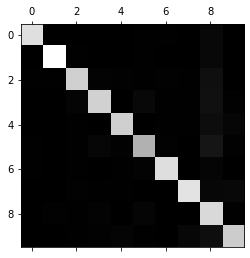

In [51]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks pretty good, since most images are on the main diagonal, which means that they were classified correctly. The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or the classifier does not perform as well on 5s as on the other digits. In fact, you can verify that both are the case.

Let's focus the plot on the errors.

In [56]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [57]:
norm_conf_mx = conf_mx / row_sums

In [58]:
norm_conf_mx

array([[9.41583657e-01, 0.00000000e+00, 3.71433395e-03, 8.44166807e-04,
        1.35066689e-03, 7.25983454e-03, 6.07800101e-03, 1.01300017e-03,
        3.79875063e-02, 1.68833361e-04],
       [0.00000000e+00, 9.49273213e-01, 5.48798576e-03, 3.55977455e-03,
        5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.03826758e-03,
        3.14446752e-02, 1.48323939e-03],
       [4.53172205e-03, 4.53172205e-03, 8.76132931e-01, 1.54414233e-02,
        1.22524337e-02, 4.53172205e-03, 1.12453844e-02, 6.04229607e-03,
        6.34441088e-02, 1.84625713e-03],
       [3.58832164e-03, 2.77279400e-03, 1.90833469e-02, 8.52552602e-01,
        3.26211059e-04, 3.31104224e-02, 4.40384929e-03, 6.52422117e-03,
        6.57315283e-02, 1.19067036e-02],
       [2.05409106e-03, 2.39643958e-03, 7.01814447e-03, 1.54056830e-03,
        8.87024991e-01, 2.05409106e-03, 5.81992468e-03, 4.62170490e-03,
        5.93974666e-02, 2.80725779e-02],
       [4.98063088e-03, 2.76701716e-03, 5.53403431e-03, 3.09905921e-02,
   

Fill the diagonal with zeros ro keep only the errors, and plot the result:

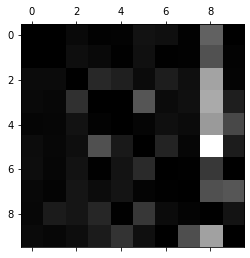

In [59]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

The rows represent actual classes, while columns represent predicted classes. The column for class 8 is quite bright, which tells us that many images get missclassified as 8s.

Analyzing individual errors can also be a very good way to gain insights on what our classifier is doing and why it is failing. For example, let's plot examples of 3s and 5s:

In [60]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]